In [1436]:
from base import *
from utils import pauli_sum, entropy
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM, COBYLA
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter 
from qiskit.circuit.library import TwoLocal
import numpy as np

### The Lipkin Model: $J=1$
$$
H_0 = \varepsilon J_z,
$$
$$
H_1 = \frac{1}{2} V \left( J_+^2 + J_-^2 \right).
$$
$$
H_2 = \frac{1}{2} W \left( -N + J_+ J_- + J_- J_+ \right).
$$
$$
\begin{equation}
H_{J = 1} =
\begin{pmatrix}-\epsilon & 0 & -V\\
 0&0&0\\
 -V&0&\epsilon
\end{pmatrix}
% \label{_auto6} \tag{6}
\end{equation}
$$

In [1386]:
eps = 1
def H(v):    
    return np.array([[-eps, 0, -v], 
                     [0, 0, 0], 
                     [-v, 0, eps]])

H(0.5)

array([[-1. ,  0. , -0.5],
       [ 0. ,  0. ,  0. ],
       [-0.5,  0. ,  1. ]])

### Classical numerical solver for the eigenvalues and the Von Neumann entropy 

$$
S(A,B)=-\mathrm{Tr}\left(\rho_{A,B}\log_2 (\rho_{A,B})\right).
$$

In [1387]:
vs = np.arange(0, 1, 0.01)
eigs = np.zeros((3, len(vs)))


for i, v in enumerate(vs):
    ham = H(v)
    eigvals, eigvecs = np.linalg.eig(H(v))
    eigs[:,i] = sorted(eigvals)




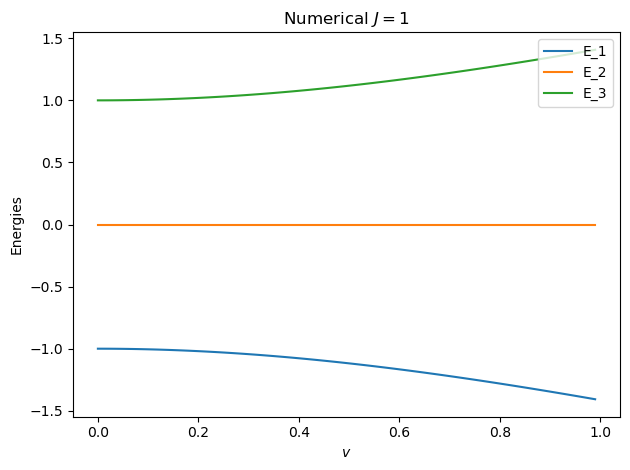

In [1388]:
plot_2D(vs, eigs, plot_count=3, title=r"Numerical $J=1$", x_title=r'$v$', 
        label = [r'E_1', r'E_2', r'E_3'], y_title='Energies')

### VQE



In [1389]:
def H(v): 
    return PauliSumOp.from_list([('ZI', (0.5 * eps)),
                                 ('IZ', (0.5 * eps)), 
                                 ('YY', (-0.5 * v)),
                                 ('XX', (0.5 * v))])

H(0)

PauliSumOp(SparsePauliOp(['ZI', 'IZ', 'YY', 'XX'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0. +0.j,  0. +0.j]), coeff=1.0)

Set up

In [1390]:
def ansatz():
    '''creates an ansatz for vqe
    inputs:
        n: int, number of qubits
    return:
        qc: QuantumCircuit object, parametrized quantum circuit with given number of qubits, with parameters 
        thetas and phis
        '''
    n=2
    qc = QuantumCircuit(n)
    theta0 = Parameter('theta0')
    phi0 = Parameter('phi0')
    theta1 = Parameter('theta1')
    phi1 = Parameter('phi1')

    qc.rx(theta0,0)
    qc.ry(phi0,0)
    qc.rx(theta1,1)
    qc.ry(phi1,1)
    qc.cnot(0,1)
    
    return qc

def prep_vqe(n):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()
    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2*n), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.

In [1391]:
n_points=100
n_qubits=2

vs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe(n_qubits)
energies = np.zeros(n_points) # containers for the energies

for i, v in enumerate(vs):
    v = v / n_points
    ham = H(v)
    print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'v = {v}, energy = {result.eigenvalue.real}')




0.5 * ZI
+ 0.5 * IZ
+ -0.0 * YY
+ 0.0 * XX
v = 0.0, energy = -0.9999998693691823
0.5 * ZI
+ 0.5 * IZ
- 0.005 * YY
+ 0.005 * XX
v = 0.01, energy = -1.0000499923476474
0.5 * ZI
+ 0.5 * IZ
- 0.01 * YY
+ 0.01 * XX
v = 0.02, energy = -1.0001999748957884
0.5 * ZI
+ 0.5 * IZ
- 0.015 * YY
+ 0.015 * XX
v = 0.03, energy = -1.0004496525050555
0.5 * ZI
+ 0.5 * IZ
- 0.02 * YY
+ 0.02 * XX
v = 0.04, energy = -1.0007996779438426
0.5 * ZI
+ 0.5 * IZ
- 0.025 * YY
+ 0.025 * XX
v = 0.05, energy = -1.001248860325979
0.5 * ZI
+ 0.5 * IZ
- 0.03 * YY
+ 0.03 * XX
v = 0.06, energy = -1.0017983774121033
0.5 * ZI
+ 0.5 * IZ
- 0.035 * YY
+ 0.035 * XX
v = 0.07, energy = -1.0024468508008033
0.5 * ZI
+ 0.5 * IZ
- 0.04 * YY
+ 0.04 * XX
v = 0.08, energy = -1.0031947393367269
0.5 * ZI
+ 0.5 * IZ
- 0.045 * YY
+ 0.045 * XX
v = 0.09, energy = -1.0040418274380774
0.5 * ZI
+ 0.5 * IZ
- 0.05 * YY
+ 0.05 * XX
v = 0.1, energy = -1.0049874824460592
0.5 * ZI
+ 0.5 * IZ
- 0.055 * YY
+ 0.055 * XX
v = 0.11, energy = -1.0060317319240

KeyboardInterrupt: 

In [ ]:
# plt.plot(vs/n_points, energies)
# plt.plot(vs/n_points, eigs[0])
plot_2D(vs/n_points, [energies, eigs[0]], plot_count=2, title="Ground state energies", x_title=r'$\lambda$', y_title='Energy', label=['vqe-qk', 'eigensolver'],
        filename='lipkin-2.pdf'), 
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
\begin{aligned}
H &= H_0 + H_1 \\
&= \frac{1}{2} (Z_1 + Z_2) + \frac{1}{2} V (X_1 \otimes X_2 + Y_1 \otimes Y_2)
\end{aligned}

In [ ]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis]'''
    qc = Qubits_2()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    qc.cnot(0, 1)
    return qc

def my_H(v):
    return pauli_sum([('ZI', (0.5 * eps)),
                      ('IZ', (0.5 * eps)), 
                      ('YY', (-0.5 * v)),
                      ('XX', (0.5 * v))])


def expectation(qc, v, n_shots=10000):
    '''the expectation value of energy for the hamiltonian'''
    coeffs = {'IZ':0.5 * eps, 'ZI': 0.5 * eps, 'XX':0.5 * v, 'YY':-0.5 * v}

    # IZ
    qc_copy = qc.copy()
    qc_copy.swap() 
    count_iz = qc_copy.measure(n_shots=n_shots)[:,0] # only the couonts, don't keep the states

    # ZI
    qc_copy = qc.copy() # make a new copy everytime
    count_zi = qc_copy.measure(n_shots=n_shots)[:,0]

    # XX
    qc_copy = qc.copy()
    qc_copy.hadamard(0)
    qc_copy.hadamard(1)
    qc_copy.cnot(1,0)
    count_xx = qc_copy.measure(n_shots=n_shots)[:,0]

    # YY
    qc_copy = qc.copy()
    qc_copy.sdag(0)
    qc_copy.hadamard(0)
    qc_copy.sdag(1)
    qc_copy.hadamard(1)
    qc_copy.cnot(1,0)
    count_yy = qc_copy.measure(n_shots=n_shots)[:,0]

    expectation = 0
    # ZI = (#00 + #01 - #10 - #11)/ number of shots
    # print(count_iz, count_zi, count_zz, count_xx)
    counts = [coeffs['IZ'] * count_iz, coeffs['ZI'] * count_zi, 
              coeffs['YY'] * count_yy, coeffs['XX'] * count_xx]
    
    # print(counts)
    for count in counts:
        # print(count)
        for i, state_count in enumerate(count):
            if i < 2:
                expectation += state_count
            else:
                expectation -= state_count
    return expectation / n_shots


qc = Qubits_2()
v = np.random.uniform(-np.pi, np.pi)
a = qc.state.conj() @ my_H(v) @ qc.state
a, expectation(qc, v)


((1+0j), 1.0069077904556984)

In [ ]:
a = my_ansatz(np.ones(4)* np.random.uniform(low=-np.pi/2, high=np.pi/2))
a

Qubit(s) in state: 
 0.99+0.01j|00⟩ + 0.07-0.07j|01⟩ + -0.00-0.01j|10⟩ + 0.07-0.07j|11⟩ 

In [ ]:
from algorithms import Vqe 

In [ ]:
n_points = 100

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=4)
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation)

my_energies = np.zeros(n_points)
vs = np.arange(n_points)
for i, v in enumerate(vs):
    v = v / n_points
    my_ham = my_H(v)
    # print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, v, 10000)
    print(f"v: {v}, energy: {min_energy}")
    my_energies[i] = min_energy



v: 0.0, energy: -1.0
v: 0.01, energy: -1.0001610000000003
v: 0.02, energy: -1.0002259999999998
v: 0.03, energy: -1.0008370000000002
v: 0.04, energy: -1.000956
v: 0.05, energy: -1.0014949999999998
v: 0.06, energy: -1.002124
v: 0.07, energy: -1.001524
v: 0.08, energy: -1.0021759999999997


KeyboardInterrupt: 

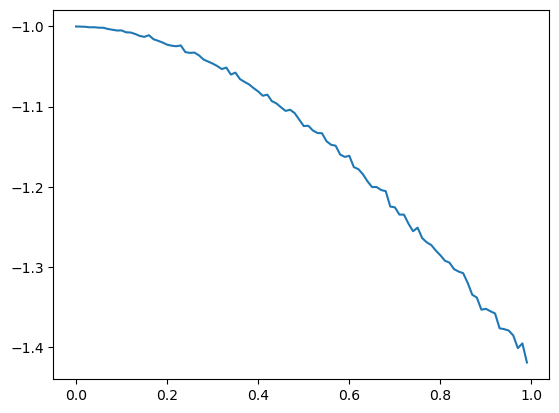

In [ ]:
plt.plot(vs/n_points, my_energies)
plt.show()

In [ ]:
# plot_2D(vs/n_points, [energies, eigs[0], my_energies], plot_count=3, title="Ground state energies", x_title=r'$\lambda$', y_title='Energy', label=['vqe-qk', 'eigensolver', 'vqe-base']
#         ,filename='lipkin-2.pdf'), 


(None,)

## J=2

In [1573]:
# constants
z_coeff = 0.5 * eps



In [1574]:

# def H(V):
#     return np.array([[-2*eps, 0, np.sqrt(6)*V, 0, 0],
#                   [0, -eps, 0, 3*V, 0],
#                   [np.sqrt(6)*V, 0, 0, 0, np.sqrt(6)*V],
#                   [0, 3*V, 0, eps, 0],
#                   [0, 0, np.sqrt(6)*V, 0, 2*eps]])

# H(0)

def my_H(v):
    
    x_coeff = -v/2
    y_coeff = v/2
    return pauli_sum([('ZIII', z_coeff), ('IZII', z_coeff), ('IIZI', z_coeff), ('IIIZ', z_coeff), # all 1 qubit combinations
                      ('XXII', x_coeff), ('XIXI', x_coeff), ('XIIX', x_coeff), ('IXXI', x_coeff), ('IXIX', x_coeff), ('IIXX', x_coeff), # all 2 qubit combinations
                      ('YYII', y_coeff), ('YIYI', y_coeff), ('YIIY', y_coeff), ('IYYI', y_coeff), ('IYIY', y_coeff), ('IIYY', y_coeff)])

my_H(0)

array([[ 2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0

In [1587]:
vs = np.arange(0, 2, 0.02)
eigs = np.zeros((16, len(vs)))


for i, v in enumerate(vs):
    ham = my_H(v)
    eigvals, eigvecs = np.linalg.eig(my_H(v))
    eigs[:,i] = sorted(eigvals)

/var/folders/jg/t3sh6cf540j_h6jc8c4mssl40000gn/T/ipykernel_80146/2813480460.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs[:,i] = sorted(eigvals)


In [1588]:
plot_2D(vs, eigs, plot_count=16, title=r"Numerical $J=1$", x_title=r'$v$', 
        label = [rf'E_{i}' for i in range(16)], y_title='Energies', filename='lipkin-eigs-4.pdf')

As we can see, every eigenvalue has a degenerate value. However $E_3$ and $E_{14}$ are energy eigenvalues that we do not get from the 5x5 matrix. 

In [1577]:
def ansatz(num_qubits, reps):
    # Create quantum circuit
    qc = QuantumCircuit(num_qubits)

    # Define parameters
    params = [Parameter(f'theta_{i}') for i in range(2 * num_qubits * (reps+1))]

    # Create the layers
    for i in range(reps): 
        # Add ry layer
        for q in range(num_qubits):
            qc.ry(params[2*(i*num_qubits + q)], q)
        # Add rz layer
        for q in range(num_qubits):
            qc.rx(params[2*(i*num_qubits + q) + 1], q)
        # Add entanglement layer (full entanglement: cz gates between every pair)
        for source in range(num_qubits):
            for target in range(source + 1, num_qubits):
                qc.cx(source, target)

    return qc




In [1578]:
def prep_vqe(n, reps=1):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    cobyla = COBYLA(maxiter = 500)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()
    ansatz = TwoLocal(n, ['rx', 'ry'], 'cx', reps=reps, entanglement='full')
    vqe = VQE(ansatz=ansatz, 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2 * n * (reps+1)), 
              estimator=estimator)

    return vqe

def H(v):
    x_coeff = -v/2
    y_coeff = v/2
    return PauliSumOp.from_list([('ZIII', z_coeff), ('IZII',z_coeff), ('IIZI', z_coeff), ('IIIZ', z_coeff), # all 1 qubit combinations
                      ('XXII', x_coeff), ('XIXI', x_coeff), ('XIIX', x_coeff), ('IXXI', x_coeff), ('IXIX', x_coeff), ('IIXX', x_coeff), # all 2 qubit combinations
                      ('YYII', y_coeff), ('YIYI', y_coeff), ('YIIY', y_coeff), ('IYYI', y_coeff), ('IYIY', y_coeff), ('IIYY', y_coeff)])


In [1579]:

n_qubits=4

vs = np.arange(0,2,0.02) # rmb to divide when used
n_points=len(vs)
vqe = prep_vqe(n_qubits, reps=2)
energies = np.zeros(n_points) # containers for the energies

for i, v in enumerate(vs):
    ham = H(v)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'v = {v}, energy = {result.eigenvalue.real}')


v = 0.0, energy = -1.9999996835575926
v = 0.02, energy = -2.00037384705447
v = 0.04, energy = -2.002457891078032
v = 0.06, energy = -2.005570184819506
v = 0.08, energy = -2.010076719886849
v = 0.1, energy = -2.0159170798726707
v = 0.12, energy = -2.0231479081786667
v = 0.14, energy = -2.0576188714649946
v = 0.16, energy = -2.0747665173463954
v = 0.18, energy = -2.0940288270825973
v = 0.2, energy = -2.115248195140388
v = 0.22, energy = -2.138363054817034
v = 0.24, energy = -2.1632957604378813
v = 0.26, energy = -2.189965708219273
v = 0.28, energy = -2.218290344559686
v = 0.3, energy = -2.2481897439967167
v = 0.32, energy = -2.279585681241857
v = 0.34, energy = -2.3124035852228784
v = 0.36, energy = -2.3465697667120593
v = 0.38, energy = -2.3820157407100435
v = 0.4, energy = -2.4186721330239616
v = 0.42, energy = -2.456479425704106
v = 0.44, energy = -2.495373880087204
v = 0.46, energy = -2.535299876960631
v = 0.48, energy = -2.5762032505377293
v = 0.5, energy = -2.6180337994574097
v = 0

ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

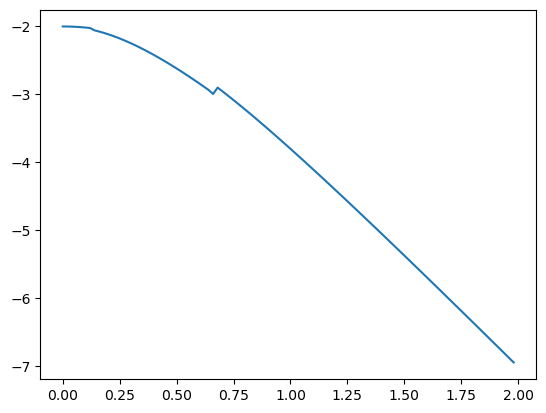

In [1581]:
plot_2D(vs, [energies,eigs[0],eigs[1], eigs[2]], plot_count=4, 
        x_title='v', y_title='Eigenvalues', title='Eigenvalues for J=2 with qiskit',
        label=['vqe-qk', 'eig' ,'eigs', 'eigs[4]'], filename='lipkin-4.pdf')
# plt.show()

In [1582]:
def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis]'''
    qubits = Qubits(4)

    params = params.reshape(4,2)
    for i in range(4):
        theta = params[i, 0]
        phi = params[i, 1]
        qubits.rx(theta, i)
        qubits.ry(phi, i)

    # more complex pattern of CNOTs for entanglement
    toffoli = np.eye(8)
    toffoli[-2:, -2:] = np.array([[0, 1], [1, 0]])
    qubits.state = np.kron(toffoli, qubits.I) @ qubits.state
    qubits.cnot(2, 3)
    qubits.cnot(1, 2)
    qubits.cnot(0, 1) 
    
    # qubits.cnot(0, 2)  # added
    # qubits.cnot(1, 3)  # added

    # print(qubits)
    return qubits


def my_ansatz(params, num_qubits=4, reps=1):
    # Create quantum circuit
    qc = Qubits(num_qubits)

    # Create the layers
    for i in range(reps): 
        for q in range(num_qubits):
            qc.ry(params[2*(i*num_qubits + q)], q)

        for q in range(num_qubits):
            qc.rx(params[2*(i*num_qubits + q) + 1], q)
        # Add entanglement layer (full entanglement: cz gates between every pair)
        for control in range(num_qubits):
            for target in range(control + 1, num_qubits):
                qc.cnot(control, target)

    return qc




In [1583]:
def expectation_2(qc, v, n_shots=1000):
    '''the expectation value of energy for the hamiltonian'''
    x_coeff = -v/2
    y_coeff = v/2
    coeffs = {'ZIII': 0.5, 'IZII': 0.5, 'IIZI': 0.5, 'IIIZ': 0.5, # all 1 qubit combinations
               'XXII': x_coeff, 'XIXI': x_coeff, 'XIIX': x_coeff, 'IXXI': x_coeff, 'IXIX': x_coeff, 'IIXX': x_coeff, # all 2 qubit combinations
               'YYII': y_coeff, 'YIYI': y_coeff, 'YIIY': y_coeff, 'IYYI': y_coeff, 'IYIY': y_coeff, 'IIYY': y_coeff}

    swaps = {'IIIZ': [(0,3)], 'IIZI': [(0,2)], 'IZII': [(0,1)],
             'XXII': [], 'XIXI': [(1, 2)], 'XIIX': [(1, 3)], 'IXXI': [(0, 2)], 'IXIX': [(0, 3)], 'IIXX': [(0, 2), (1, 3)], 
             'YYII': [], 'YIYI': [(1, 2)], 'YIIY': [(1, 3)], 'IYYI': [(0, 2)], 'IYIY': [(0,3)], 'IIYY': [(0, 2), (1, 3)]}
    
    # print(qc)
    counts = np.zeros((16, 16))

    for i, operators in enumerate(coeffs.keys()):

        # print(i, operators)
        qc_copy = qc.copy()

        if operators == 'ZIII':
            counts[i] = qc_copy.measure(n_shots)[:, 0]
            # print(operators, counts[i])
            continue
        
        cnot_pair = []
        for j, operator in enumerate(operators):
            if operator == 'X':
                # print('X')
                cnot_pair.append(j)
                qc_copy.hadamard(j)

            if operator == 'Y': 
                # print('Y')
                cnot_pair.append(j)
                qc_copy.sdag(j)
                qc_copy.hadamard(j)
        
        if cnot_pair:
            qc_copy.cnot(cnot_pair[1], cnot_pair[0])
        
        for pair in swaps[operators]:
            qc_copy.swap(pair[0], pair[1])
        
        # print(qc_copy)
        counts[i] = qc_copy.measure(n_shots)[:, 0]
        # print(operators, counts[i])
    
    # print(counts/n_shots)
    exp_val = 0
    coeffs_z = 0.5 * np.ones(4)
    coeffs_x = -0.5*v*np.ones(6)
    coeffs_y = 0.5*v*np.ones(6)
    coeffs = np.concatenate((coeffs_z, coeffs_x, coeffs_y))
    counts *= coeffs
    # counts = counts * np.array(list(coeffs.values()))
    # print(counts.shape)
    # print(coeffs.values())
    for count in counts:
        # print(count)
        for i, state_count in enumerate(count):
            # print(i ,state_count)
            if i < 8:
                exp_val += state_count
            else:
                exp_val -= state_count
    # print(exp_val)
    return  exp_val / n_shots

a, qc
#print(qc.swap(3,0))
test = 0.5
for _ in range(10):
    a = np.random.uniform(low=-np.pi, high=np.pi, size=8)
    a = np.ones(8)
    qc = my_ansatz(a)
    ex = qc.state.conj() @ my_H(test) @ qc.state
    b = expectation_2(qc, test, 10000)
    print(f"{ex.real:.3f}, {b:.3f}")

-0.925, 2.232
-0.925, 2.238
-0.925, 2.259
-0.925, 2.239
-0.925, 2.245
-0.925, 2.237
-0.925, 2.224
-0.925, 2.241
-0.925, 2.246
-0.925, 2.258


Qubit(s) in state: 
 0.18+0.36j|0000⟩ + -0.34-0.17j|0001⟩ + -0.13+0.08j|0010⟩ + 0.05-0.13j|0011⟩ + -0.02+0.10j|0100⟩ + -0.04-0.08j|0101⟩ + 0.25+0.08j|0110⟩ + -0.24+0.08j|0111⟩ + 0.09+0.04j|1000⟩ + -0.09+0.02j|1001⟩ + 0.14-0.22j|1010⟩ + 0.02+0.25j|1011⟩ + 0.05+0.14j|1100⟩ + -0.12-0.08j|1101⟩ + 0.39-0.07j|1110⟩ + -0.25+0.28j|1111⟩ 

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [174. 148.  26.  24.   7.   8.  68.  54.   7.  10.  65.  66.  21.  20.
  160. 142.]
 [176. 159.  10.  11.   4.   6.  24.  20.  28.  17.  68.  71.  78.  46.
  134. 148.]
 [165.  24.   7.  81.  10.  66.  20. 150. 144.  24.  10.  63.   7.  64.
   35. 130.]
 [107. 123. 107.  94.  24.  12.  91.  86.  45.  36.   7.   8.  25.  18.
  121.  96.]
 [ 27.   7.  13.  16. 166.  81.  78. 169. 128.  60.  63. 144.  18.   8.
    8.  14.]
 [ 17.   4.   4.  42.   9.   2.  18.   6.  89.  13. 111.  71. 213.  47.
   36. 318.]
 [ 36.  24. 128. 106.  92.  67. 127. 105.  29.  35.  18.  11.  97. 103.


-9.072

In [1589]:
n_points = 100
# print(Vqe)

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=8)
# my_vqe = Vqe(my_ansatz, init_points, expectation=expectation_2)
# my_vqe = Vqe(my_ansatz, init_points, expectation=exp_mt)
my_vqe = Vqe(my_ansatz, init_points)
# print(my_vqe)
my_energies = np.zeros(n_points)
vs = np.linspace(0, 2, n_points)
for i, v in enumerate(vs):
    my_ham = my_H(v)
    # print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, v, 1000)
    print(f"v: {v}, energy: {min_energy.real}")
    my_energies[i] = min_energy.real


v: 0.0, energy: -1.9999999999947515
v: 0.020202020202020204, energy: -2.000620444674518
v: 0.04040404040404041, energy: -2.0025149082047045
v: 0.06060606060606061, energy: -2.0057330538632954
v: 0.08080808080808081, energy: -2.0103240907379907
v: 0.10101010101010102, energy: -2.01633620424251
v: 0.12121212121212122, energy: -2.0238159276132905
v: 0.14141414141414144, energy: -2.0328074521510815
v: 0.16161616161616163, energy: -2.043351882835113
v: 0.18181818181818182, energy: -2.0554865933863136
v: 0.20202020202020204, energy: -2.0692449580727303
v: 0.22222222222222224, energy: -2.0846540092319605
v: 0.24242424242424243, energy: -2.1017358626099285
v: 0.26262626262626265, energy: -2.120506002982693
v: 0.2828282828282829, energy: -2.1409731007954464
v: 0.30303030303030304, energy: -2.16313871572549
v: 0.32323232323232326, energy: -2.1869971325185413
v: 0.3434343434343435, energy: -2.212535405213666
v: 0.36363636363636365, energy: -2.239733518417705
v: 0.38383838383838387, energy: -2.268

/Users/bukser/mambaforge/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_optimize.py:3397: ComplexWarning: Casting complex values to real discards the imaginary part
  direc[-1] = direc1


v: 1.191919191919192, energy: -4.2338084291088585
v: 1.2121212121212122, energy: -4.292918766529079
v: 1.2323232323232325, energy: -4.3522304810743115
v: 1.2525252525252526, energy: -4.411734305315983
v: 1.272727272727273, energy: -4.471421505997193
v: 1.292929292929293, energy: -4.531283850358913
v: 1.3131313131313131, energy: -4.591313571645014
v: 1.3333333333333335, energy: -4.65150333886815
v: 1.3535353535353536, energy: -4.711846228580107
v: 1.373737373737374, energy: -4.772335696327316
v: 1.393939393939394, energy: -4.832965555431388
v: 1.4141414141414144, energy: -4.893729953671401
v: 1.4343434343434345, energy: -4.954623345195276
v: 1.4545454545454546, energy: -5.015640481927746
v: 1.474747474747475, energy: -5.07677638809116
v: 1.494949494949495, energy: -5.138026344799922
v: 1.5151515151515154, energy: -5.199385874060647
v: 1.5353535353535355, energy: -5.260850724688175
v: 1.5555555555555556, energy: -5.322416857953854
v: 1.575757575757576, energy: -5.384080435117114
v: 1.595

In [1590]:
# plot_2D([vs,np.arange(0,2, 0.01)], [my_energies, eigs[0]], plot_count=2, multi_x=True)
plot_2D(vs, [my_energies, energies,eigs[0],eigs[1], eigs[2]], plot_count=5, 
        x_title=r'v/\epsilon', y_title='Eigenvalues', title='Eigenvalues for J=2 with qiskit',
        label=['vqe-base','vqe-qk', 'eig' ,'eigs', 'eigs[4]'], filename='lipkin-4.pdf')
# plt.plot(vs, my_energies)
# plt.show()